### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

In [3]:
from pydantic import BaseModel
from typing import Any

In [4]:
# from ewatercycle.forcing import HBVforcing

Download plugin model

In [5]:
# pip install ewatercycle-HBV==1.3.8

In [6]:
# pip uninstall ewatercycle-HBV -y

In [7]:
# pip install --upgrade git+https://github.com/Daafip/ewatercycle-hbv.git@dev

#### set up paths

In [8]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

In [9]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "1999-09-01T00:00:00Z"
HRU_id = 1620500
alpha = 1.26

In [10]:
from ewatercycle.forcing import sources

In [11]:
camels_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha,
                          )

#### import model

In [12]:
# from ewatercycle.models import HBV

In [13]:
from ewatercycle_DA.local_models.HBV import HBVLocal

In [14]:
truth_model = HBVLocal(forcing=camels_forcing)

In [15]:
truth_parameters = np.array([3.2,   0.9,  700,    1.2,   .16,   4,     .08,  .0075, 0.5])
truth_initial_storage = np.array([20,  10,  50,  100, 10])

In [16]:
config_file, _ = truth_model.setup(
            parameters=','.join([str(p) for p in truth_parameters]),
            initial_storage=','.join([str(s) for s in truth_initial_storage]),
           )

In [17]:
truth_model.initialize(config_file)

In [18]:
Q_m = []
time = []
while truth_model.time < truth_model.end_time:
    truth_model.update()
    Q_m.append(truth_model.get_value("Q"))
    time.append(truth_model.time_as_datetime.date())
truth_model.finalize()

In [19]:
truth = pd.DataFrame(Q_m, columns=["Q_m"],index=time)

In [20]:
rng = np.random.default_rng()  # Initiate a Random Number Generator
def add_normal_noise(like_sigma) -> float:
    """Normal (zero-mean) noise to be added to a state

    Args:
        like_sigma (float): scale parameter - pseudo variance & thus 'like'-sigma

    Returns:
        sample from normal distribution
    """
    return rng.normal(loc=0, scale=like_sigma)  # log normal so can't go to 0 ?

In [21]:
truth['Q'] = truth.apply(lambda x: x.Q_m + add_normal_noise(0.5) , axis=1)
truth.index = truth.apply(lambda x: pd.Timestamp(x.name),axis=1)
truth.index.name = "time"

<Axes: xlabel='time'>

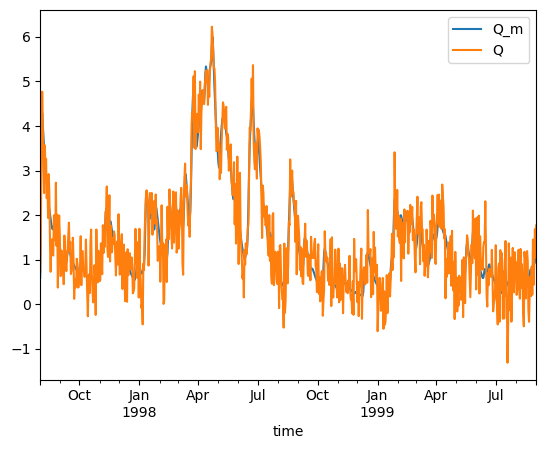

In [22]:
truth.plot()

In [23]:
ds_obs = xr.Dataset(data_vars=truth[['Q']])

In [24]:
current_time = str(datetime.now())[:-10].replace(":","_")
ds_obs_dir = observations_path / f'truth_model_HBV_{current_time}.nc'
if not ds_obs_dir.is_file():
    ds_obs.to_netcdf(ds_obs_dir)

#### import DA function:

In [25]:
# pip uninstall ewatercycle_DA -y

In [26]:
# pip install git+https://github.com/Daafip/eWaterCycle-DA@dev

In [27]:
from ewatercycle_DA import DA

In [28]:
n_particles = 100

In [29]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [30]:
# ## Array of initial storage terms - we keep these constant for now 
# ##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

# # set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [31]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [32]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })

In [33]:
from ewatercycle_DA.local_models.HBV import HBVLocal

Extra step to make 'custom' local model work

In [34]:
ensemble.loaded_models.update({'HBVLocal': HBVLocal})

In [35]:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                    forcing=[camels_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

if fails to initialize, run in cmd:
[link1](https://stackoverflow.com/questions/65272764/ports-are-not-available-listen-tcp-0-0-0-0-50070-bind-an-attempt-was-made-to)
[link2](https://asheroto.medium.com/docker-error-an-attempt-was-made-to-access-a-socket-in-a-way-forbidden-by-its-access-permissions-15a444ab217b)
```bash
net stop winnat
netsh int ipv4 set dynamic tcp start=49152 num=16384
netsh int ipv6 set dynamic tcp start=49152 num=16384
net start winnat
````

In [36]:
# # #### run if initialize fails 
# ensemble.finalize()

Load camels observation file and write to a netcdf file

## setup DA

This sets up all the require data assimilation information

In [37]:
lst_like_sigma = [0.5] * 14 + [0]
hyper_parameters = {'like_sigma_weights' : 0.005,
                    'like_sigma_state_vector' : lst_like_sigma,
                   }

In [38]:
def H(Z):
    if len(Z) == 15:
        return Z[-1] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be 13 but is {len(Z)}")

In [39]:
ensemble.initialize_da_method(ensemble_method_name = "PF", 
                              hyper_parameters=hyper_parameters,                           
                              state_vector_variables = "all", # the next three are keyword arguments but are needed. 
                              observation_path = ds_obs_dir,
                              observed_variable_name = "Q",
                              measurement_operator = H, 
                           
                            )

## Run

In [40]:
ref_model = ensemble.ensemble_list[0].model

In [41]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)

time = []
assimilated_times = []
lst_state_vector = []
lst_Q_prior = []
lst_Q_obs = []
lst_Q = [] 
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    lst_Q_prior.append(ensemble.get_value("Q").flatten())
    # update every 3 steps 
    if i % 3 == 0: 
        assimilate = True 
        assimilated_times.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    else:
        assimilate = False
    ensemble.update(assimilate=assimilate)
     
    lst_state_vector.append(ensemble.get_state_vector())
    lst_Q.append(ensemble.get_value("Q").flatten())
    lst_Q_obs.append(ensemble.ensemble_method.obs)

# end model - IMPORTANT! when working with dockers
ensemble.finalize()

100%|█████████████████████████████████████████████████████████████████████████████████| 761/761 [10:38<00:00,  1.19it/s]


In [42]:
Q_m_arr = np.array(lst_Q).T
Q_m_arr_prior = np.array(lst_Q_prior).T
state_vector_arr = np.array(lst_state_vector)

### process the numpy data into easily acessed data types

In [43]:
save, load = False, False 
current_time = str(datetime.now())[:-10].replace(":","_")

In [44]:
n_particles

100

In [45]:
if not load:
    df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])
    df_ensemble_prior = pd.DataFrame(data=Q_m_arr_prior[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

### process states and parameters into xarrys

In [46]:
##### Save? 
if save:
    df_ensemble.to_feather(output_path /f'df_ensemble_{current_time}.feather')
if load:
    df_ensemble = pd.read_feather(sorted(glob.glob(str(output_path/'df_ensemble_*.feather')))[-1]) # read last
    time = list(df_ensemble.index)

In [47]:
# df_ensemble = df_ensemble.iloc[:1000]
# time = time[:1000]
# state_vector_arr = state_vector_arr[:1000,:,:]

In [48]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

In [49]:
if not load:    
    data_vars = {}
    for i, name in enumerate(param_names + stor_names+ ["Q"]):
        storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                       name=name,
                                       dims=["EnsembleMember","time"],
                                      coords=[np.arange(n_particles),df_ensemble.index],
                                      attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                               "history": f"Storage term results from ewatercycle_HBV.model",
                                            "description":"Moddeled values",
                                                 "units": "mm"})
        data_vars[name] = storage_terms_i

    ds_combined = xr.Dataset(data_vars,
                             attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                    "history": f"Storage term results from ewatercycle_HBV.model",}
                              )

In [50]:
##### Save? 
if save:
    ds_combined.to_netcdf(output_path / f'combined_ds_{current_time}.nc')
    
if load:
    # ds_combined = xr.open_dataset(glob.glob(str(output_path / 'combined_ds_*.nc'))[-1])
    ds_combined = xr.open_dataset(glob.glob(str(output_path / 'combined_ds_2024-04-03*.nc'))[0])
    time = ds_combined.time.values
    n_particles = len(ds_combined.EnsembleMember)

## Plotting

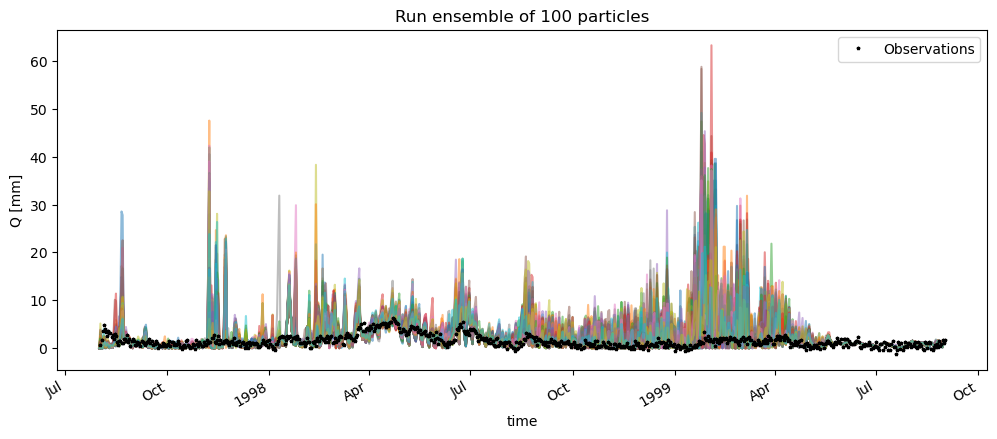

In [51]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax.legend(bbox_to_anchor=(1,1))
df_ensemble.plot(ax=ax,alpha=0.5,zorder=-1,legend=False)
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
# ax.set_xlim((pd.Timestamp('2004-08-01'),pd.Timestamp('2005-12-01')))
# ax.set_xlim((pd.Timestamp('1998-08-01'),pd.Timestamp('2001-12-01')))
# ax.set_ylim((0,10))
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png")

Can calculate the mea as a reference

In [52]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [53]:
mean_ensemble = df_ensemble.T.mean()
NSE_mean_ens = calc_NSE(ds_obs['Q'].values,mean_ensemble.loc[time])

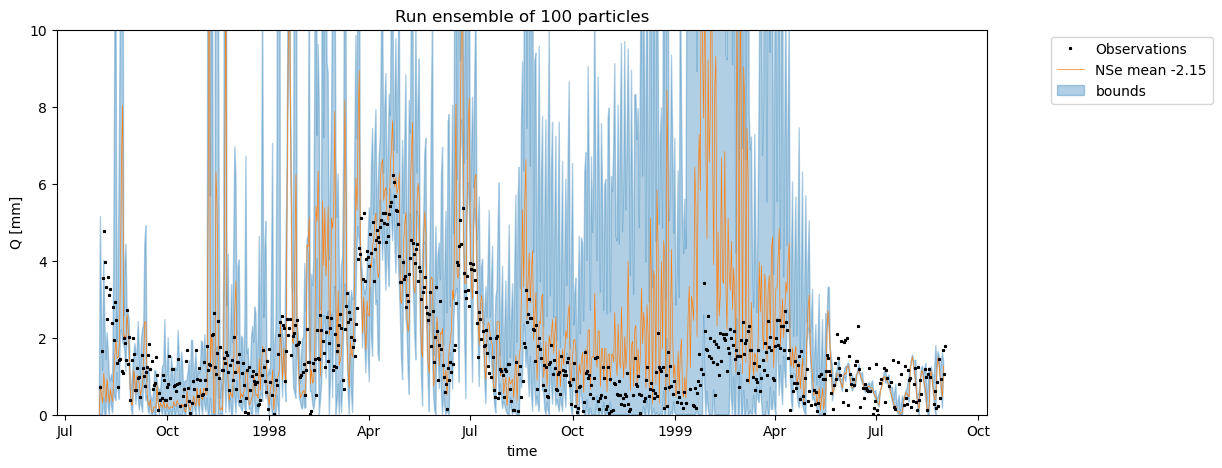

In [54]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"NSe mean {NSE_mean_ens:.2f}",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
ax.set_ylim((0,10))
# ax.set_xlim((pd.Timestamp('2000-08-01'),pd.Timestamp('2004-06-01')))
# ax.set_xlim((pd.Timestamp('2004-08-01'),pd.Timestamp('2005-12-01')))
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png",bbox_inches="tight",dpi=400);

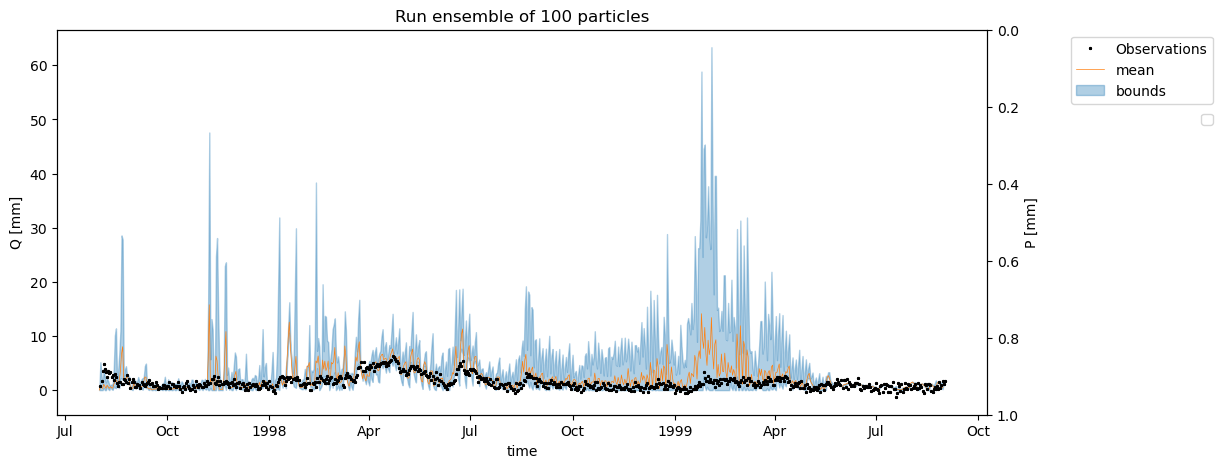

In [55]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
# ax_pr.bar(df_ensemble.index,ds['pr'].values[:len(time)],zorder=-15,label="Precipitation",color="grey")
ax_pr.legend(bbox_to_anchor=(1.25,0.8))

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_bounds_P_{current_time}.png",bbox_inches="tight",dpi=400);

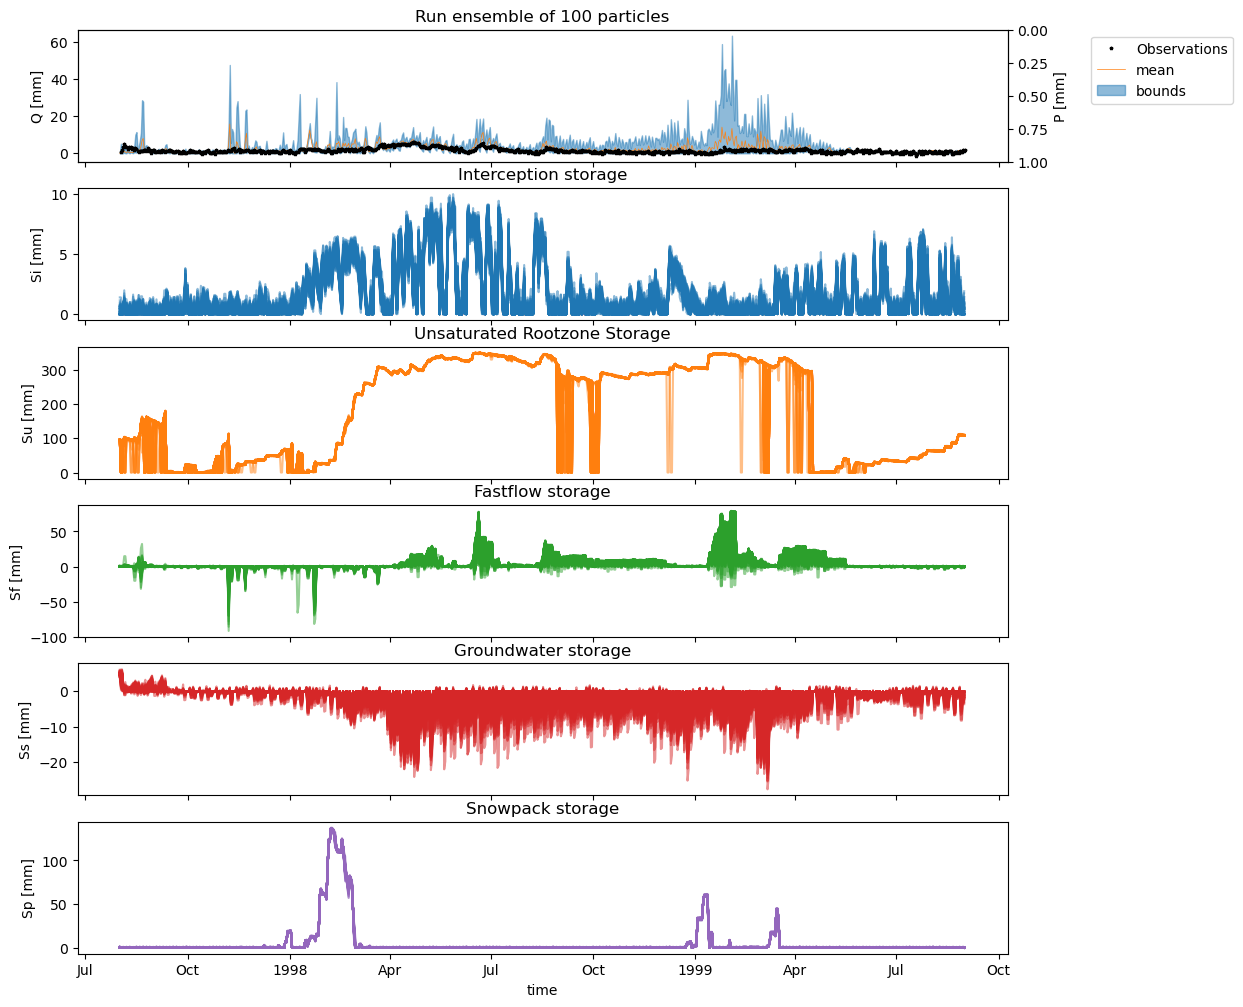

In [56]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)

ax = axs[0]
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
# ax_pr.bar(df_ensemble.index,ds['pr'].values[:len(time)],zorder=-10,label="Precipitation",color="grey")

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")

ax.set_title(f"Run ensemble of {n_particles} particles");

for i, S_name in enumerate(S_names):
    for j in range(n_particles):
        ds_combined[stor_names[i]].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(S_name)
        axs[i+1].set_ylabel(f'{stor_names[i]} [{units[stor_names[i]]}]')

# remove all unncecearry xlabels
[ax.set_xlabel(None) for ax in axs[:-1]]
# [ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

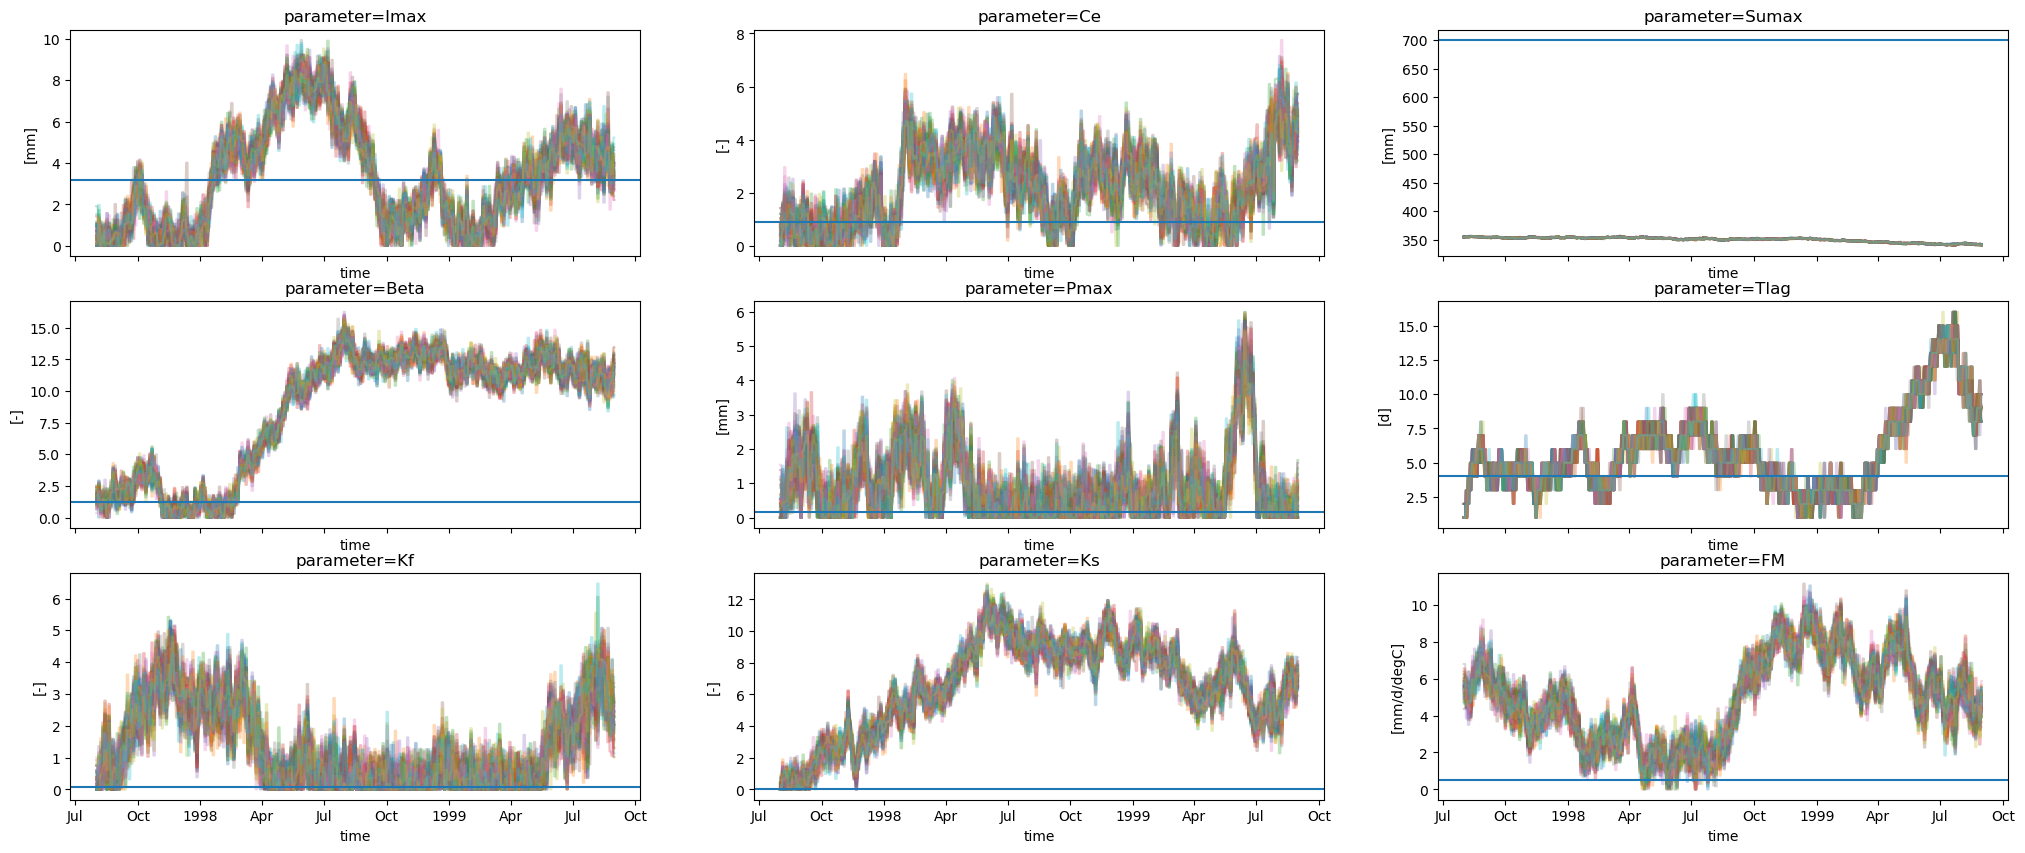

In [57]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    for i in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=i).plot(ax=ax,alpha=0.3)
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')
    ax.axhline(truth_parameters[j])
if save:
    fig.savefig(figure_path /  f"ensemble_run_for__{n_particles}_particles_parameters_{current_time}.png",bbox_inches="tight",dpi=400)

In [58]:
param_names_0 = param_names[:4]
param_names_1 = param_names[4:]

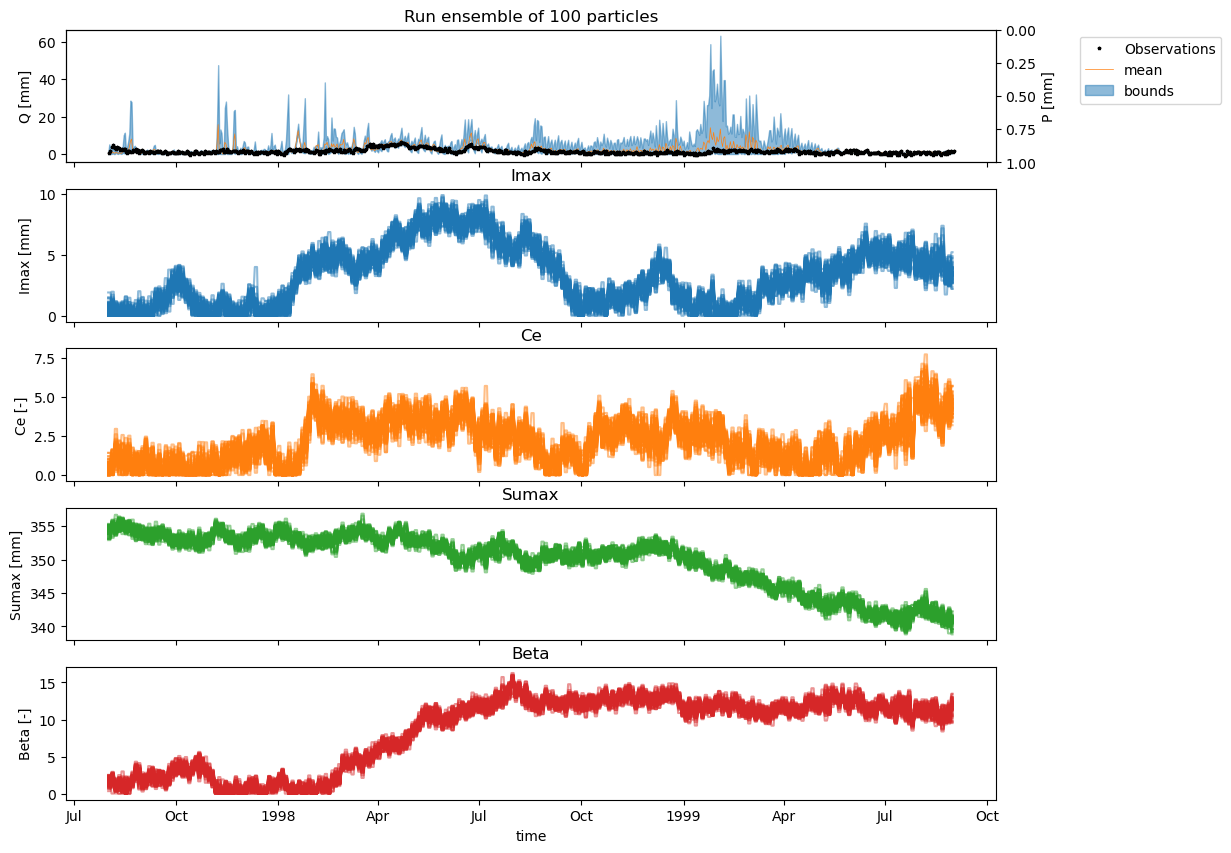

In [59]:
n=5
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)

ax = axs[0]
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
# ax_pr.bar(df_ensemble.index,ds['pr'].values[:len(time)],zorder=-10,label="Precipitation",color="grey")

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")

ax.set_title(f"Run ensemble of {n_particles} particles");


for i, parameter in enumerate(param_names_0):
    for j in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(parameter)
        axs[i+1].set_ylabel(f'{param_names_0[i]} [{units[param_names_0[i]]}]')

# remove all unncecearry xlabels
[ax.set_xlabel(None) for ax in axs[:-1]]
# [ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

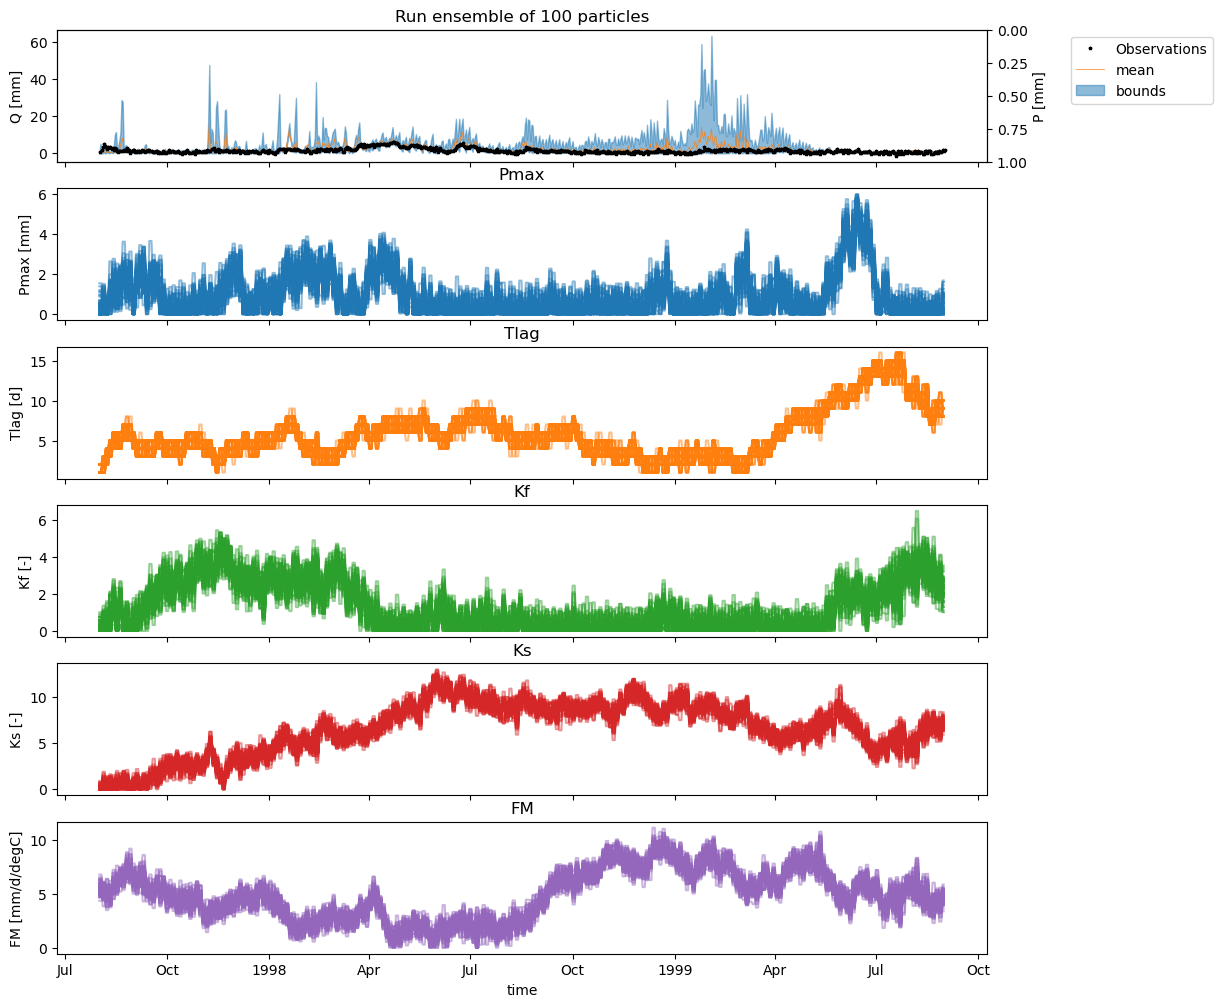

In [60]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)

ax = axs[0]
ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
# ax_pr.bar(df_ensemble.index,ds['pr'].values[:len(time)],zorder=-10,label="Precipitation",color="grey")

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")

ax.set_title(f"Run ensemble of {n_particles} particles");


for i, parameter in enumerate(param_names_1):
    for j in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(parameter)
        axs[i+1].set_ylabel(f'{param_names_1[i]} [{units[param_names_1[i]]}]')
# remove all unncecearry xlabels
[ax.set_xlabel(None) for ax in axs[:-1]]
# [ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

# analyse posterio & prior 

good :105, 500, 1000 ,<br>
bad: > 1350

In [61]:
m = 3
n = 14
offset = 102
selected_time = time[offset:offset+m*n]
resample = np.array([time if index%3==0 else None for index, time in enumerate(selected_time)])
resample = resample[~(resample == None)]

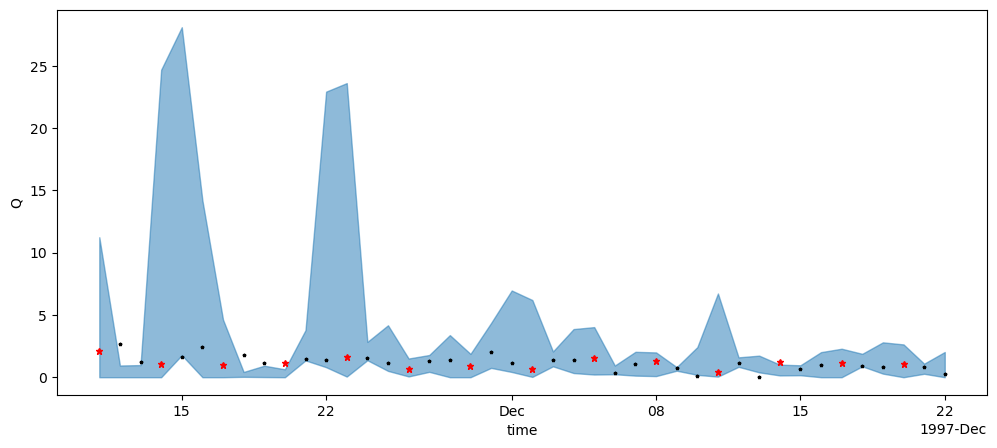

In [62]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ds_obs['Q'].sel(time=selected_time).plot(ax=ax, lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ds_obs['Q'].sel(time=resample).plot(ax=ax, lw=0,marker="*",ms=5,zorder=0,label="Resample steps",color='r')
ax.fill_between(df_ensemble.loc[selected_time].index,df_ensemble.loc[selected_time].T.min(),df_ensemble.loc[selected_time].T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds");

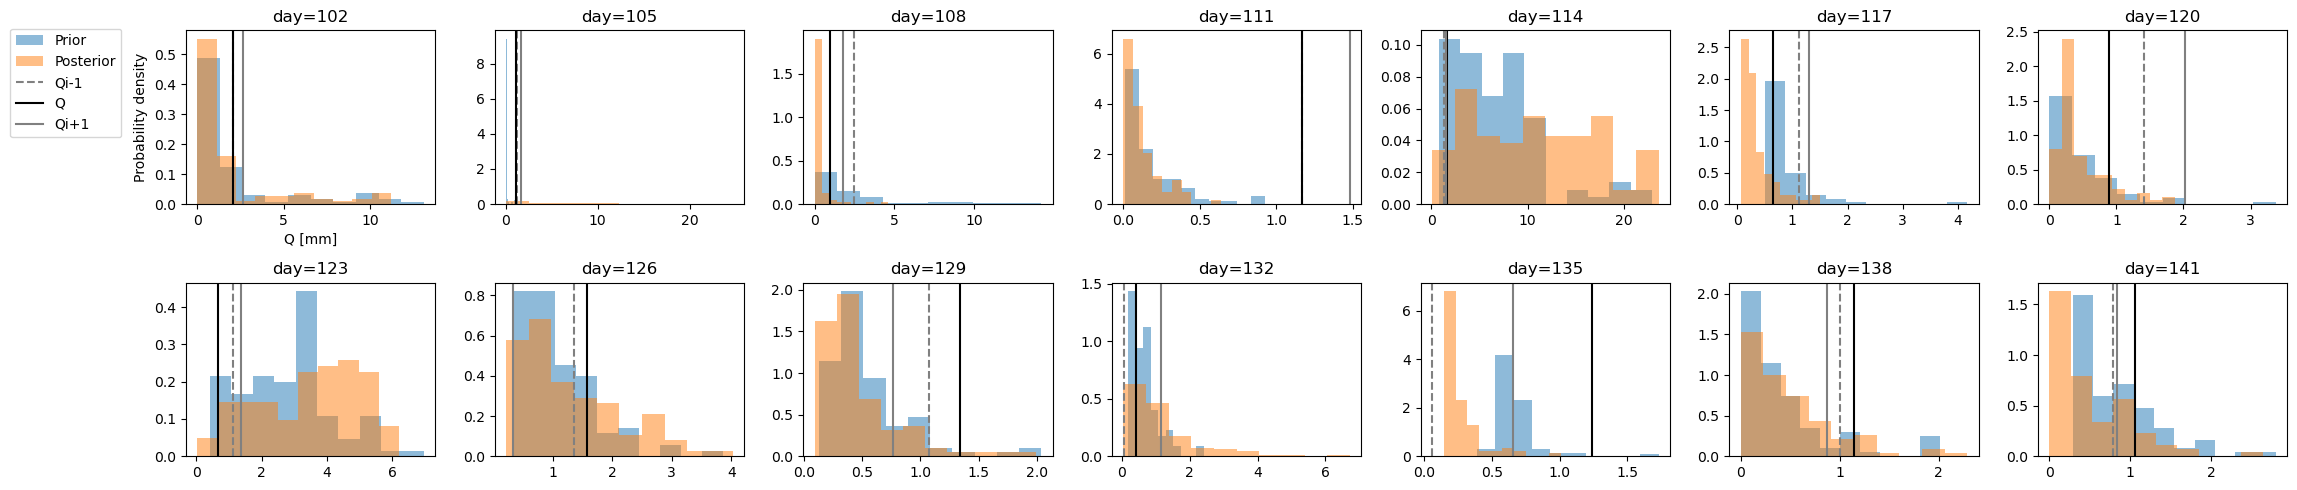

In [63]:
fig, axs = plt.subplots(2,n//2, figsize=(23,5))
axs = axs.flatten()
counter=0
for index, i in enumerate(range(offset, offset+ (m * n))):
    if i % 3 == 0:
        ax = axs[index//3]
        # ds_combined_prior["Q"].sel(time=time[i]).plot.hist(ax=ax,density=True, color="C1",zorder=-1,alpha=0.5,label="Prior (i)");
        ax.hist(df_ensemble_prior.loc[time[i]],density=True,color="C0",zorder=1,alpha=0.5,label="Prior");
        ax.hist(df_ensemble.loc[time[i]],density=True,color="C1",zorder=1,alpha=0.5,label="Posterior");
        
        ax.axvline(ds_obs["Q"].sel(time=time[i-1], method="nearest").values,color="grey",ls="--", label="Qi-1")
        ax.axvline(ds_obs["Q"].sel(time=time[i], method="nearest").values,color="k", label="Q")
        ax.axvline(ds_obs["Q"].sel(time=time[i+1], method="nearest").values,color="grey", label="Qi+1")
        
        ax.set_title(f"day={i}")
        if counter == 0:
            ax.legend(bbox_to_anchor=(-0.23,1.05))
            ax.set_xlabel("Q [mm]")
            ax.set_ylabel("Probability density")
            counter+=1
fig.tight_layout()

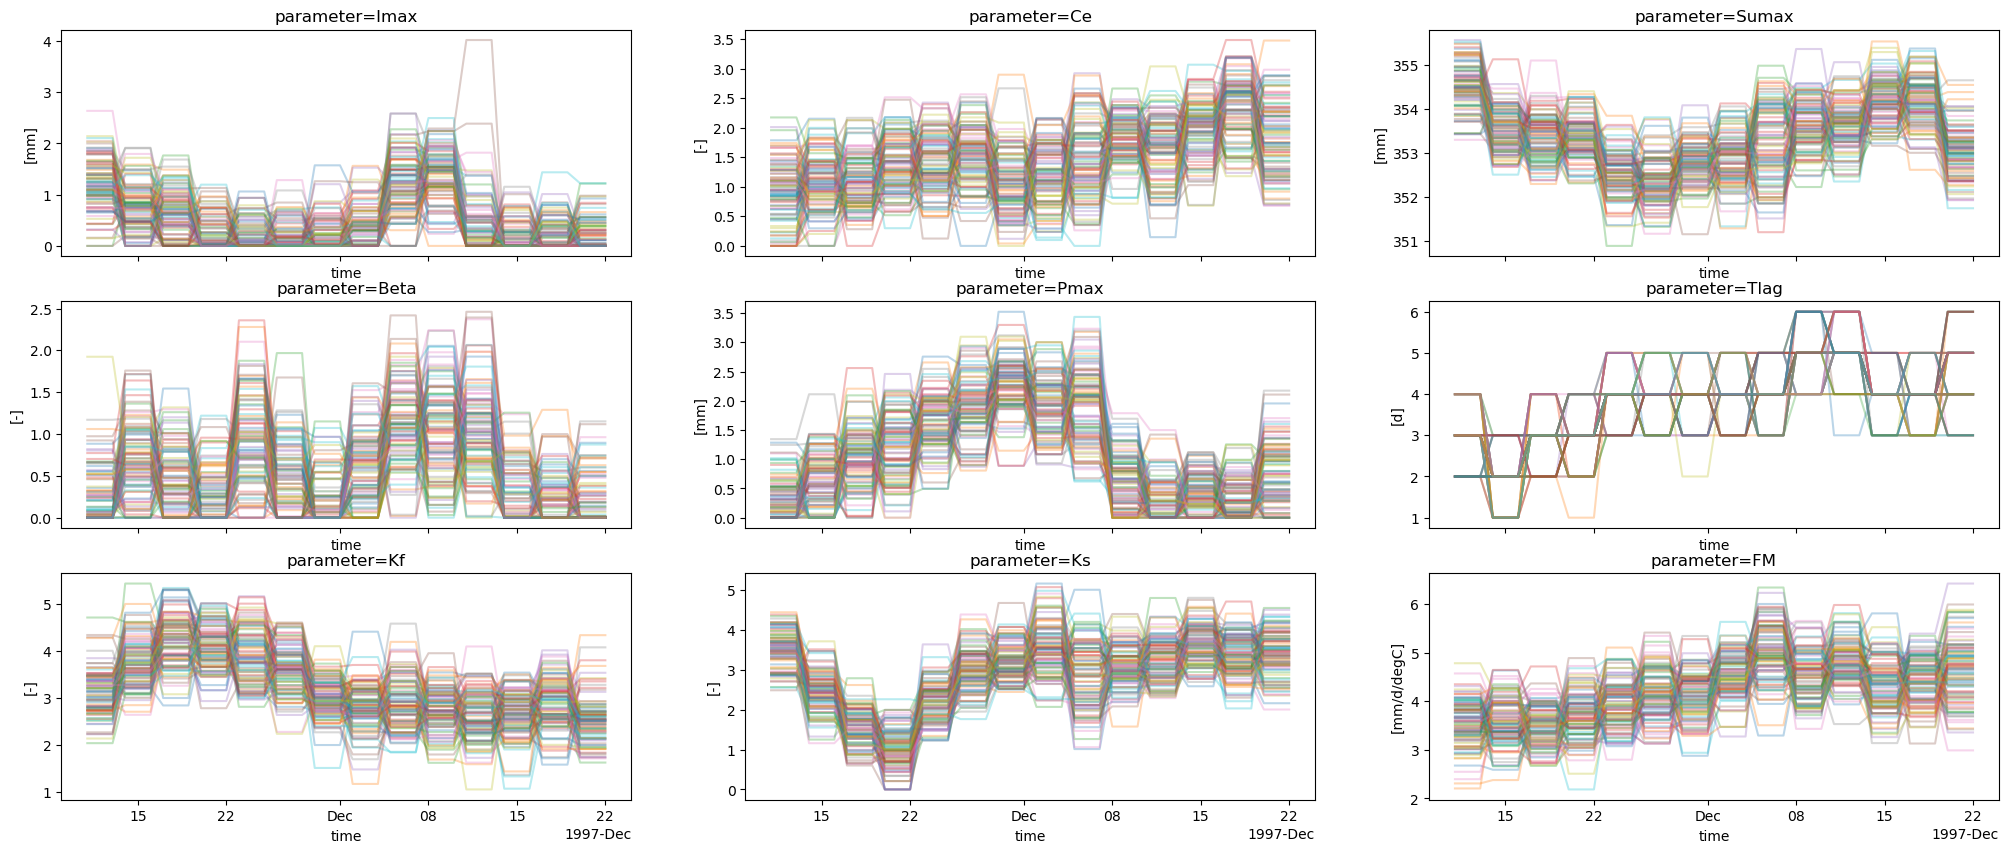

In [64]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    for i in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=i).sel(time=selected_time).plot(ax=ax,alpha=0.3)
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')
if save:
    fig.savefig(figure_path /  f"ensemble_run_for__{n_particles}_particles_parameters_{current_time}.png",bbox_inches="tight",dpi=400)